In [61]:
import pandas as pd
from datetime import datetime  
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sn
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,BatchNormalization,Dropout
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras

In [69]:
#Merge the datasets and perform data preprocessing
data1 = pd.read_excel("the total emissions data from three carbon-emitting sectors.xlsx")
data2 = pd.read_excel("Data on carbon emissions from different industries(pre day).xlsx")
data_time = []
for i in data1['日期']:
    original_datetime_str = str(i)
    original_datetime = datetime.strptime(original_datetime_str, "%Y-%m-%d %H:%M:%S")  
    formatted_date_str = original_datetime.strftime("%d/%m/%Y")  
    data_time.append(formatted_date_str)
data_time = pd.Series(data_time)
data1['日期']=data_time
merged_df = pd.merge(data1, data2, left_on='日期', right_on='date', how='left')  
merged_dfs = merged_df[100:]
merged_dfs.to_excel("the total emissions data from four carbon-emitting sectors.xlsx",index=False)
df = merged_df.drop(columns=['日期','iso_code','国家'])
X = df[100:]
y=X['carbon emission']
X = X.drop(columns=['carbon emission'])
X = X.drop(columns=['daily_people_vaccinated_per_hundred'])
#X = X.dropna() 
new_list = [item.replace('_', ' ') for item in X.columns]
X.columns = new_list
X=X.drop(columns=['date'])
X

,total vaccinations,people vaccinated,people fully vaccinated,total boosters,daily vaccinations raw,daily vaccinations,total vaccinations per hundred,people vaccinated per hundred,people fully vaccinated per hundred,total boosters per hundred,daily vaccinations per million,daily people vaccinated,CAC40,Brent Crude Oil Spot Prices,Natural Gas Futures,European Renewable Energy Total Return,FTSE100,DAX30,S&P500,STOXX50,Rotterdam,US 3Ybond,EN Carbon market,Domestic Aviation,Ground Transport,Industry,International Aviation,Power,Residential
100,18.963015,18.636559,17.693278,11.328510,15.175345,14.994220,3.643097,3.316728,2.373044,-3.912023,8.884610,14.583710,0.004461,0.001602,0.010194,0.040298,0.007538,0.013264,0.007346,0.008666,0.011582,-0.063039,0.040298,0.027999,2.70689,2.166760,0.177519,2.30173,1.874420
101,19.006570,18.677473,17.744831,11.351770,14.949462,15.053907,3.686627,3.357594,2.424803,-3.912023,8.944289,14.638442,0.000075,-0.001747,-0.008829,-0.030585,-0.000846,0.000049,-0.010490,-0.002705,0.015635,0.016978,-0.030585,0.024138,2.66557,1.592140,0.162824,1.69131,0.957888
102,19.026639,18.696048,17.769244,11.371719,15.240672,15.072472,3.706719,3.376221,2.449279,-3.912023,8.962904,14.653750,-0.018747,0.003201,0.007814,-0.021694,-0.024972,-0.018392,-0.008712,-0.019397,0.011863,0.020001,-0.021694,0.021490,2.70077,2.013210,0.137359,2.13861,1.226120
103,19.047198,18.715088,17.794018,11.392666,15.356886,15.086104,3.727379,3.395179,2.474014,-3.912023,8.976515,14.667048,0.001906,0.011412,0.004727,-0.011758,0.008119,0.002013,-0.021683,0.000347,0.012306,0.158385,-0.011758,0.025444,2.72488,2.001310,0.160401,2.12597,1.332950
104,19.094016,18.756183,17.857274,11.453027,15.131098,15.047478,3.774139,3.436243,2.537657,-3.912023,8.937875,14.620464,0.016707,-0.005473,-0.002698,0.024031,0.005549,0.017432,0.026907,0.017580,-0.005255,-0.076060,0.024031,0.025792,2.62411,1.776500,0.174167,1.88716,1.547390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,20.672739,19.638758,19.608421,19.457975,9.210040,9.498222,5.352806,4.318821,4.288540,4.138042,3.401197,3.931826,0.001156,0.015909,-0.018223,0.044329,0.010115,-0.000679,-0.014189,-0.000348,0.000431,-0.023915,0.044329,0.041312,2.74650,1.276850,0.455036,1.79077,2.484880
732,20.672749,19.638758,19.608421,19.458005,9.442166,9.418817,5.352853,4.318821,4.288540,4.138042,3.295837,3.951244,-0.001588,-0.004573,0.049821,0.006910,-0.002719,-0.002731,0.009645,-0.001978,-0.001726,0.003452,0.006910,0.041828,2.75155,1.067410,0.469977,1.49702,2.262740
733,20.672755,19.638758,19.608421,19.458025,9.181323,9.320091,5.352853,4.318821,4.288540,4.138042,3.218876,3.912023,-0.000341,-0.006213,0.014666,0.002925,0.000361,0.001124,0.001659,-0.000749,0.002157,-0.004440,0.002925,0.044195,2.72297,0.914358,0.493764,1.28237,2.281430
734,20.672786,19.638759,19.608421,19.458087,8.729882,8.765459,5.352853,4.318821,4.288540,4.138202,2.639057,3.637586,0.000396,0.009181,0.003442,0.026573,0.003558,0.002146,0.005652,0.001527,0.012848,-0.016200,0.026573,0.037572,2.39502,1.017080,0.448773,1.42644,2.431930


In [100]:
#Random Forest Feature Correlation
rf = RandomForestRegressor(n_estimators=20,max_depth=15)  
rf.fit(X, y)
importances = rf.feature_importances_    
features = list(X.columns)  
#feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
treefeature_importances = pd.Series(importances, index=features)
for i in  range(treefeature_importances.shape[0]):
    if treefeature_importances[i] < 0.001:
        treefeature_importances[i]*=100
    if treefeature_importances[i]<0.01:
        treefeature_importances[i]*=10
treefeature_importances

#Pearson correlation coefficient
df = merged_df.drop(columns=['日期','iso_code','国家'])
X = df[100:]
X = X.drop(columns=['daily_people_vaccinated_per_hundred'])
#X = X.dropna() 
new_list_1 = [item.replace('_', ' ') for item in X.columns]
X.columns = new_list_1
X = X.drop(columns=['date'])
x1_corr = X.corr()
corrfeature_importances = abs(x1_corr['carbon emission'][1:])

#spearman correlation coefficient
X = X.drop(columns=['carbon emission'])
from scipy.stats import spearmanr  
spearman_correlations = []  
for feature in np.array(X).T: 
    rho, _ = spearmanr(feature, y)  
    spearman_correlations.append(rho)  
spearman_correlations = abs(np.array(spearman_correlations))  
spearman_importances = pd.Series(spearman_correlations, index=features)

In [77]:
#Fusion using Fisher's z-transformation method
def fisher_z_transform(r):  
    return 0.5 * np.log((1 + r) / (1 - r))  
  
def inverse_fisher_z_transform(z):  
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)  
  
def combine_correlations(w1, w2, w3):   
    if len(w1) != len(w2) or len(w2) != len(w3):  
        raise ValueError("All correlation coefficient lists must have the same length")  
    combined_z = []  
    for r1, r2, r3 in zip(w1, w2, w3):  
        z1 = fisher_z_transform(r1)  
        z2 = fisher_z_transform(r2)  
        z3 = fisher_z_transform(r3)  
        combined_z_value = (z1 + z2 + z3) / 3  # Simple averaging of z-scores  
        combined_z.append(combined_z_value)  
    combined_r = [inverse_fisher_z_transform(z) for z in combined_z]  
    return combined_r  
  
w1 = treefeature_importances  
w2 = corrfeature_importances    
w3 = spearman_correlations    
  
combined_correlation = combine_correlations(w1, w2, w3)  
combined_importances = pd.Series(combined_correlation, index=features)

<Axes: >

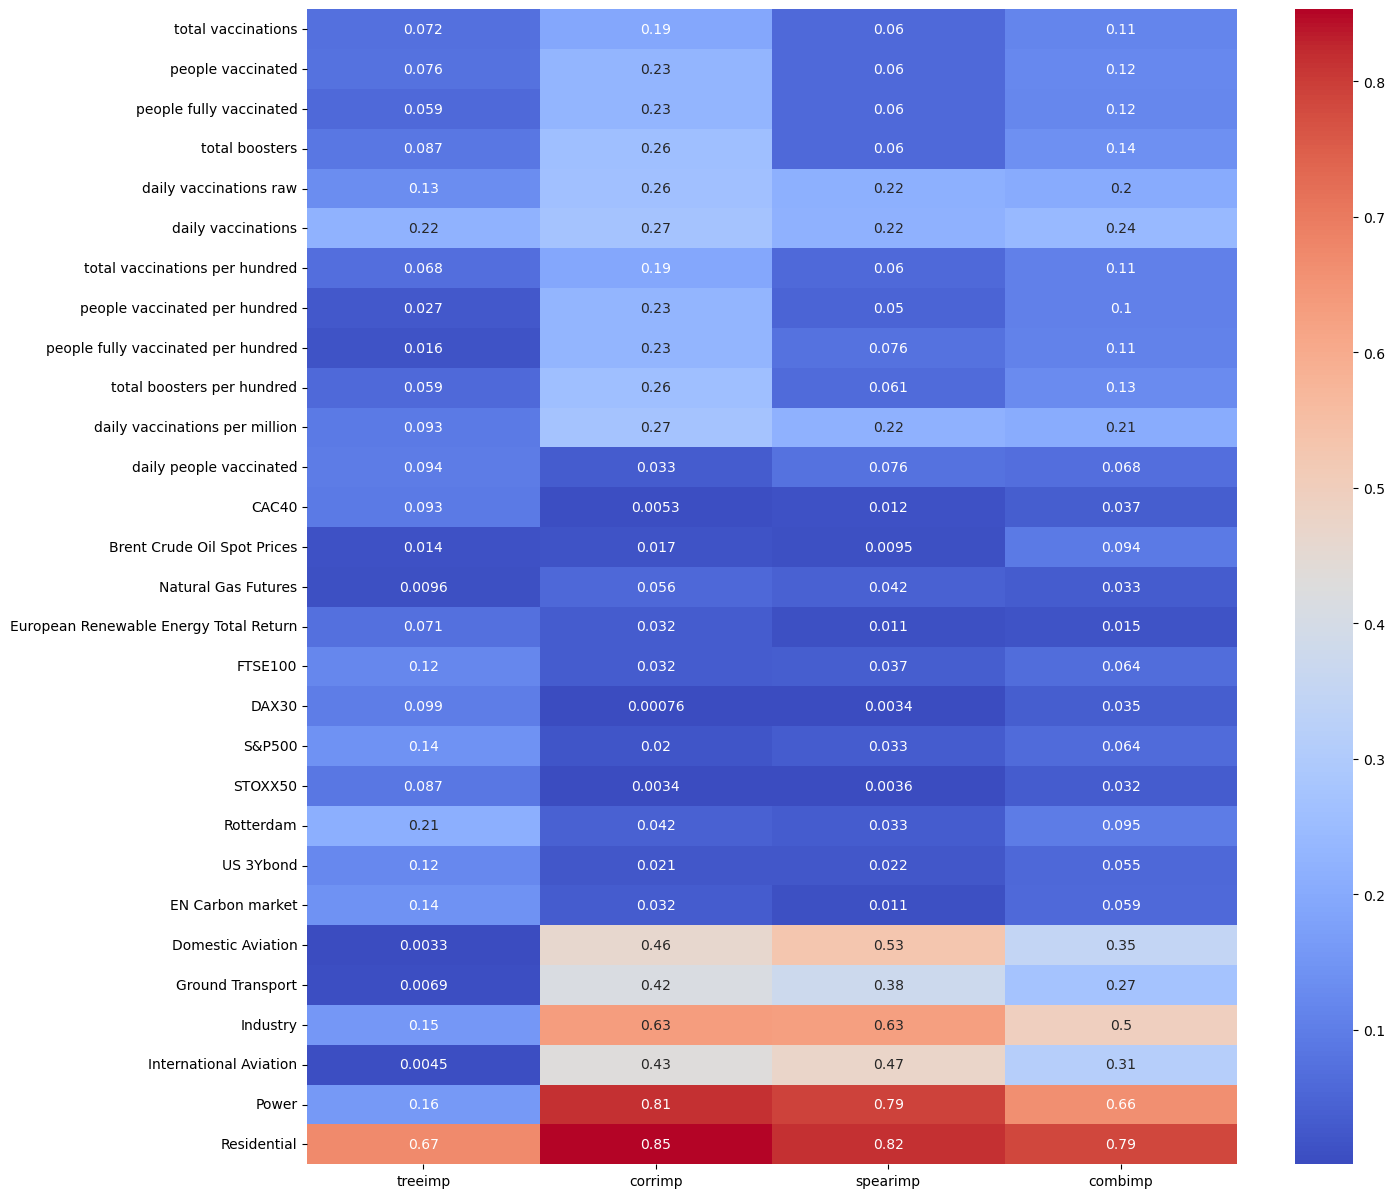

In [119]:
#correlation analysis of all variables
A = pd.concat((treefeature_importances,corrfeature_importances,spearman_importances,combined_importances),axis=1)
A.columns = ['treeimp','corrimp','spearimp','combimp']
plt.figure(figsize=(15,15))
sn.heatmap(aaa,cmap='coolwarm',annot=True)
aaa = A

<Axes: >

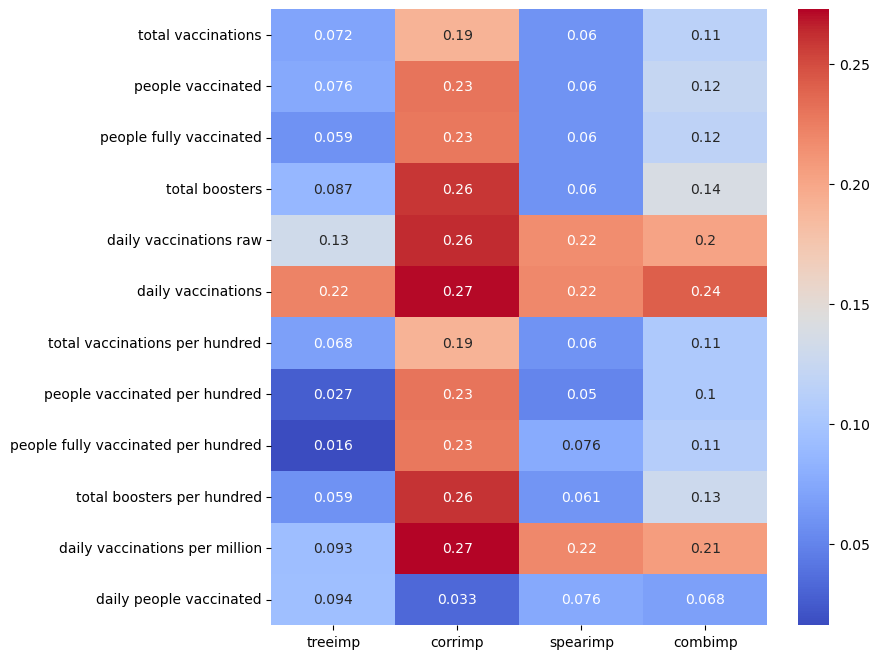

In [125]:
#partial correlation analysis of variables
aaa_1 = aaa.iloc[:12]
plt.figure(figsize=(8,8))
sn.heatmap(aaa_1,cmap='coolwarm',annot=True)

<Axes: >

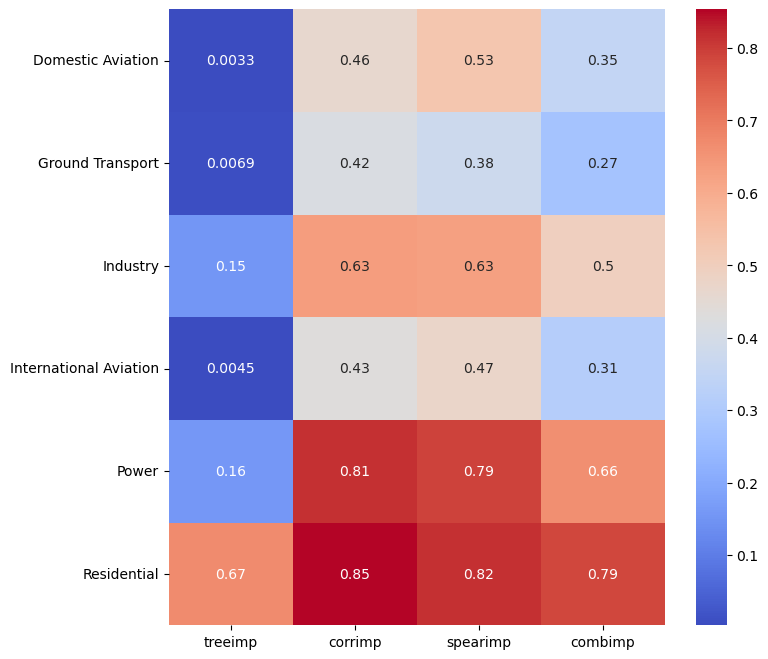

In [127]:
#partial correlation analysis of variables
aaa_2 = aaa.iloc[23:]
plt.figure(figsize=(8,8))
sn.heatmap(aaa_2,cmap='coolwarm',annot=True)

<Axes: >

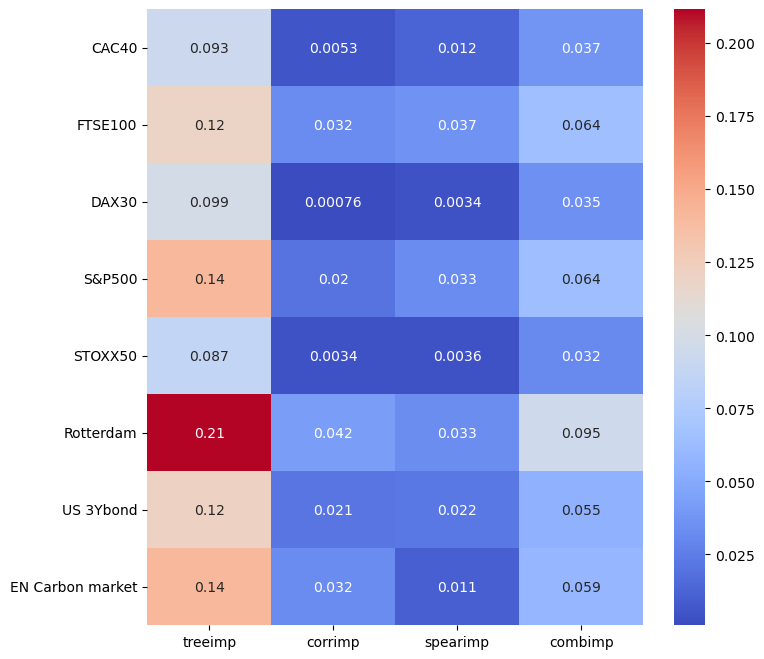

In [132]:
#partial correlation analysis of variables
aaa_3 = aaa.iloc[[12,16,17,18,19,20,21,22]]
plt.figure(figsize=(8,8))
sn.heatmap(aaa_3,cmap='coolwarm',annot=True)